<a href="https://colab.research.google.com/github/AyushGupta51379/COMP_5331_Project_Fake_News_Detection/blob/master/MVNN_Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVNN

This piece of work is an implementation of Multi-domain Visual Neural Network (MVNN), which is first proposed in the paper [Exploiting Multi-domain Visual Information for Fake News Detection](https://arxiv.org/abs/1908.04472).

In [3]:
# some basic things to include
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# some preprocessing techniques
from scipy.fftpack import dct

# custom dataset
from torch.utils.data.dataset import Dataset

# this is only required for Google Colab
from google.colab import drive

these modules and dataset require to be downloaded (unless they are executed under a repository)

In [5]:
# DCT modules
#print("DCT Module:")
#!gdown --id 1MtVZXrFkLTLQgOhFhbYIUrXT-FMKH2hH
#from dct import DCT, DFT

# download the dataset
print("Dataset:")
!gdown --id 1gjbSZV5NjjIVOqSP-yTCqXcGPX9PnYn5
!unzip -q '/content/MM17-WeiboRumorSet.zip'

Dataset:
Downloading...
From: https://drive.google.com/uc?id=1gjbSZV5NjjIVOqSP-yTCqXcGPX9PnYn5
To: /content/MM17-WeiboRumorSet.zip
1.35GB [00:16, 80.3MB/s]


In [6]:

'''
Usage:
as image preprocessor by calling DCT() as a transform

input: 128*128*3 PIL image
output: 64*256 torch array (histogram)

[128*128] => (crop) => [256 * [8*8]] => (DCT_2d) => [256 * [8 * 8]] => reshape => [256 * 64]  
'''

class DCT(object):
    def __init__(self):
        self.BLOCK_HEIGHT = 8
        self.BLOCK_WIDTH = 8
        self.BLOCK_SIZE = (self.BLOCK_HEIGHT, self.BLOCK_WIDTH)

    def div_block(self, img, block_size):
        img_height = img.height
        img_width = img.width
        block_height = block_size[0]
        block_width = block_size[1]
        assert(img_height % block_height == 0)
        assert(img_width % block_width == 0)

        blocks = []
        for i in range(0,img_height,block_height):
            for j in range(0,img_width,block_width):
                box = (j, i, j+block_width, i+block_height)
                block = np.array(img.crop(box))
                blocks.append(block)
        return np.array(blocks)

    def dct2(self, array_2d):
        return dct(dct(array_2d.T, norm = 'ortho').T, norm = 'ortho')

    def _dct2(self, array_2d):
        return dct(dct(array_2d, norm = 'ortho').T, norm = 'ortho').T

    def __call__(self, img):
        image = img
        blocks = self.div_block(image, self.BLOCK_SIZE)
        b_blocks, g_blocks, r_blocks = blocks[:, :, :, 0], blocks[:, :, :, 1], blocks[:, :, :, 2]
        test_blocks = (b_blocks + g_blocks + r_blocks) / 3 # naive greyscale
        result = np.array([self._dct2(test_block) for test_block in test_blocks])
        # return a torch.tensor
        return torch.from_numpy(result.reshape(256, 64).T).float()

    def __repr__(self):
        return "Simply DCT. What do you expect?"

'''
Usage: Same as DCT()

input: 64*256 torch array (histogram)
output: 64*256 torch array (frequency histogram)
'''
class DFT(object):
    def __init__(self):
        pass

    def __call__(self, freq):
        # convert into complex form containing real and imaginary part
        cmplx = torch.from_numpy(np.zeros((freq.shape[0], freq.shape[1], 2)))
        cmplx[:, :, 0] += freq
        out = torch.fft(cmplx, 1, normalized=True)[:, :, 0]
        return out

    def __repr__(self):
        return "Simply DFT. What do you expect?"


'''
input: PIL loaded image
output: PIL image, in YCbCr color space
'''
class Ycbcr_convert():
    def __init__(self):
        pass

    def __call__(self, img):
        return img.convert('YCbCr')

    def __repr__(self):
        return "Convert a PIL Image from RGB to YCbCr" 

## Train/Test Dataset

In [7]:
## Define the constant and utility function

# mainfolder = 'drive/My Drive/COMP5331 Fall 2020/MM17-WeiboRumorSet/'
mainfolder = 'MM17-WeiboRumorSet/'
subfolders = {'nonrumor_images': 0, 'rumor_images': 1}
image_height_pixel, image_width_pixel = 224, 224
image_height_freq, image_width_freq = 128, 128
tform_pixel = transforms.Compose([
    transforms.Resize((image_height_pixel,image_width_pixel), interpolation=Image.BICUBIC),
    transforms.ToTensor()
])
tform_freq = transforms.Compose([
    transforms.Resize((image_height_freq,image_width_freq), interpolation=Image.BICUBIC),
    Ycbcr_convert(),
    DCT(),
    DFT()
])

def imshow(np_image):
    plt.figure(figsize = (5,5))
    plt.imshow(np_image) # it should be a numpy array
    plt.show()

### Some remarks from AG  
When you use GPU runtime in Colab, apart from the original VM running the notebook, Google will instantiate a new VM with GPU so that parallel computations are forwarded to VM with GPU. \\
Here we load all the data (~1.35GB, while Nvidia Tesla K80 has 12GB RAM) into memory in the beginning. Hence the data transfer between 2 VMs will only be called once, rather than every mini-batch. This is the point which takes most time, while in the training section later it will exhibit huge speedup.

In [8]:
class WeiboRumorDataset(Dataset):
    def __init__(self, tform_pixel, tform_freq, folder, subfolders):        
        self.tform_pixel = tform_pixel
        self.tform_freq = tform_freq
        self.mainfolder = folder
        self.subfolders = subfolders        
        self.data = []
        # load the entire dataset into memory
        for subfolder, label in subfolders.items():
            current = os.path.join(self.mainfolder, subfolder)
            filenames = os.listdir(current)
            for filename in filenames:
                self.data.append([os.path.join(subfolder, filename), label])
            print("[%s]: %d image loaded." % (current, len(filenames)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        filepath, label = self.data[idx]
        img = Image.open(os.path.join(self.mainfolder, filepath)).convert('RGB')     
        pixel_input = self.tform_pixel(img)
        freq_input = self.tform_freq(img)
        out = [pixel_input, freq_input, label]
        return out

[MM17-WeiboRumorSet/nonrumor_images]: 5318 image loaded.
[MM17-WeiboRumorSet/rumor_images]: 7954 image loaded.
Total no. of images:  13272


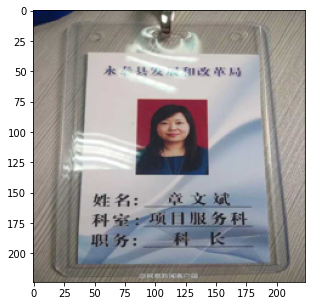

Frequency domain shape: torch.Size([64, 256])
Label: 0
Total no. of train set images:  10617
Total no. of test set images:  2655
classes: ['nonrumor_images', 'rumor_images']


In [9]:
# visualize information of the dataset

dataset = WeiboRumorDataset(tform_pixel, tform_freq, mainfolder, subfolders)
count = dataset.__len__()
print('Total no. of images: ', count)

pixel_input, freq_input, label = dataset.__getitem__(0)
imshow(pixel_input.transpose(0, 1).transpose(1, 2))
print("Frequency domain shape:", freq_input.shape)
print("Label:", label)

# 80% train, 20% test
trainset, testset = torch.utils.data.random_split(dataset, [int(count*0.8), count-int(count*0.8)])
print('Total no. of train set images: ', len(trainset))
print('Total no. of test set images: ', len(testset))

labels = dataset.subfolders # the dataset saves the subfolder's name as the labels
classes = list(labels.keys()) # convert dict keys into list
print('classes:', classes)

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True) 
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True) 

## Subnetworks

In [20]:
class CNN(nn.Module):
    def __init__(self, image_height, image_width):
        super(CNN, self).__init__()

        # NOTE:
        # 1. Before each ReLu, a BatchNorm2d layer is added to accelerate convergence (also did by the authors of the paper)

        # Conv Model 1
        self.conv_M1 = nn.Sequential(nn.Conv2d( 3, 32, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(32),  # (N,  3, 128, 128) --> (N, 32, 128, 128); add padding = 1 for kernel size = 3 to avoid changing output size
                                     nn.Conv2d(32, 32, 1), nn.ReLU(),   nn.BatchNorm2d(32),             # (N, 32, 128, 128) --> (N, 32, 128, 128);
                                     nn.MaxPool2d(2))                                                   # (N,  3, 128, 128) --> (N, 32,  64,  64);
                                     
        # Conv Model 2
        self.conv_M2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(64),  # (N, 32, 64, 64) --> (N, 64, 64, 64)
                                     nn.Conv2d(64, 64, 1), nn.ReLU(), nn.BatchNorm2d(64),               # (N, 64, 64, 64) --> (N, 64, 64, 64)
                                     nn.MaxPool2d(2))                                                   # (N, 64, 64, 64) --> (N, 64, 32, 32)

        # Conv Model 3
        self.conv_M3 = nn.Sequential(nn.Conv2d(64, 64, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(64),  # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.Conv2d(64, 64, 1), nn.ReLU(), nn.BatchNorm2d(64),               # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.MaxPool2d(2))                                                   # (N, 64, 32, 32) --> (N, 64, 16, 16)

        # Conv Model 4
        self.conv_M4 = nn.Sequential(nn.Conv2d( 64, 128, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(128), # (N,  64, 16, 16) --> (N, 128, 16, 16)
                                     nn.Conv2d(128, 128, 1), nn.ReLU(), nn.BatchNorm2d(128),              # (N, 128, 16, 16) --> (N, 128, 16, 16)
                                     nn.MaxPool2d(2))                                                     # (N, 128, 16, 16) --> (N, 128,  8,  8)
        
        #===== For each branch =====%
        # Note:
        # 1. Flatten convolution layer before FC layer, the input column size = 64 neurons * pooled output size
        # 2. Since image_height and image_width are fed from outside, we need to ensure the type to int after division, otherwise gives bugs.
        # 3. Need to add a dropout layer with a prob of 0.5 after FC layer (see the reference paper)
        # 4. Before each FC layer, a BatchNorm2d layer is added to accelerate convergence

        self.conv_br1 = nn.Sequential(nn.Conv2d(32, 64, 1),
                                      nn.Flatten(1, -1),    # flatten from the 2nd dim (1) to the last dim (-1)
                                      nn.BatchNorm1d(int(64*image_height*image_width/2/2)),
                                      nn.Linear(int(64*image_height*image_width/2/2), 64),
                                      nn.Dropout(0.5))

        self.conv_br2 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(1, -1),     
                                      nn.BatchNorm1d(int(64*image_height*image_width/4/4)),         
                                      nn.Linear(int(64*image_height*image_width/4/4), 64),
                                      nn.Dropout(0.5))

        self.conv_br3 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(1, -1),    
                                      nn.BatchNorm1d(int(64*image_height*image_width/8/8)),
                                      nn.Linear(int(64*image_height*image_width/8/8), 64),
                                      nn.Dropout(0.5))

        self.conv_br4 = nn.Sequential(nn.Conv2d(128, 64, 1),
                                      nn.Flatten(1, -1),              
                                      nn.BatchNorm1d(int(64*image_height*image_width/16/16)),
                                      nn.Linear(int(64*image_height*image_width/16/16), 64),
                                      nn.Dropout(0.5))

        # FC layer to 2 classes (fake or real) with Softmax to compute prob along the dimension of concatenated features (64*4 = 256)
        self.fc = nn.Sequential(nn.BatchNorm1d(256),
                                nn.Linear(256, 2),
                                nn.Dropout(0.5))    
                                        #nn.Softmax(dim=1)) # AG: no need for softmax if we use cross entropy loss function, which will also offer prob.
                                                            # Now the loss in the training part converges!!
    
    def forward(self, x):
        out1 = self.conv_M1(x)      # Branch 1
        out2 = self.conv_M2(out1)   # Branch 2
        out3 = self.conv_M3(out2)   # Branch 3
        out4 = self.conv_M4(out3)   # Branch 4
        v1 = self.conv_br1(out1)
        v2 = self.conv_br2(out2)
        v3 = self.conv_br3(out3)
        v4 = self.conv_br4(out4)
        v_cat = torch.cat((v1, v2, v3, v4), dim=1)

        # print("\n v1 size:", v1.shape)
        # print("\n v2 size:", v2.shape)
        # print("\n v3 size:", v3.shape)
        # print("\n v4 size:", v4.shape)
        # print("\n v_cat size:", v_cat.shape)
        return v1, v2, v3, v4, v_cat

class CNN_GRU(CNN):
    def __init__(self, image_height, image_width):
        super(CNN_GRU, self).__init__(image_height, image_width)
        # if input size = (batch_size(N),  channels = 3,  image height = 128, image width = 128)
        self.gru1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)
        
       
    def forward(self, x):
        v1, v2, v3, v4, v_cat = super().forward(x)
        
        v1 = v1.unsqueeze(0) # add an extra dimension to feed into the gru model (4, 64) --> (1, 4, 64)
        v2 = v2.unsqueeze(0)
        v3 = v3.unsqueeze(0)
        v4 = v4.unsqueeze(0)

        # backward GRU (1st layer) which reads from v4 to v1 
        out4_layer1, h4_backward = self.gru1(v4)
        out3_layer1, h3_backward = self.gru1(v3, h4_backward)
        out2_layer1, h2_backward = self.gru1(v2, h3_backward)
        out1_layer1, h1_backward = self.gru1(v1, h2_backward)

        out1_layer2, h1_forward = self.gru2(out1_layer1, h1_backward)
        out2_layer2, h2_forward = self.gru2(out2_layer1, h1_backward)
        out3_layer2, h3_forward = self.gru2(out3_layer1, h2_backward)
        out4_layer2, h4_forward = self.gru2(out4_layer1, h3_backward)

        # concatenating the forward hidden state and the backward hidden state along the feature dimension --> (1, N, 64)
        L1 = torch.squeeze(torch.cat((h1_forward, h1_backward), dim=2), dim=0) # --> (N, 64)
        L2 = torch.squeeze(torch.cat((h2_forward, h2_backward), dim=2), dim=0)
        L3 = torch.squeeze(torch.cat((h3_forward, h3_backward), dim=2), dim=0)
        L4 = torch.squeeze(torch.cat((h4_forward, h4_backward), dim=2), dim=0)

        # L_cat: (N, 4, 64)
        L_cat = torch.stack((L1, L2, L3, L4), dim=1)

        # print("\n L_cat size:", L_cat.shape)       
        # p = self.classifier(L_cat)

        return L1, L2, L3, L4, L_cat

class Frequent_Domain_Subnetwork(nn.Module):
    def __init__(self):
        super(Frequent_Domain_Subnetwork, self).__init__()
        self.backbone = nn.Sequential(nn.Conv1d(64, 32, 3, padding=1),
                             nn.MaxPool1d(2),
                             nn.Conv1d(32, 64, 3, padding=1),
                             nn.MaxPool1d(2),
                             nn.Conv1d(64, 128, 3, padding=1),
                             nn.MaxPool1d(2),
                             nn.Flatten(),
                             nn.Linear(4096, 64),
                             nn.ReLU(),
                             nn.Linear(64, 64))

    def forward(self, x):
        out = self.backbone.forward(x)
        return out    

In [23]:
class MVNN(nn.Module):
    def __init__(self, image_height_pixel, image_width_pixel):
        super().__init__()
        # subnetworks
        self.pixel_subnet = CNN_GRU(image_height_pixel, image_width_pixel)
        self.freq_subnet = Frequent_Domain_Subnetwork()
        # attention
        self.output_len = 5
        self.dimensions = 64
        self.v = nn.Parameter(torch.rand(self.dimensions, 1))
        self.W = nn.Linear(self.dimensions, self.dimensions)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        # final FC
        self.Wc = nn.Linear(self.dimensions, 2)


    def forward(self, x_pixel, x_freq):
        dimensions = self.dimensions
        output_len = self.output_len

        L1, L2, L3, L4, L_cat = self.pixel_subnet(x_pixel)      
        L0 = self.freq_subnet(x_freq)

        L_all = torch.stack((L0, L1, L2, L3, L4), dim=1) # Bx5x64
        batch_size, output_len, dimensions = L_all.shape
        L_all = self.W(L_all.reshape(batch_size * output_len, dimensions))
        L_all = L_all.reshape((batch_size, output_len, dimensions))
        f = self.tanh(L_all.reshape(batch_size, output_len, dimensions))

        # Bx5x64 bmm 1x64x1 => Bx5x1 => Bx5
        a = self.softmax(torch.matmul(f, self.v).view(batch_size, -1)) 
        # Bx1x5 bmm Bx5x64 => Bx1x64 => Bx64
        u = torch.bmm(a.unsqueeze(1), L_all).view(batch_size, -1)
        out = self.Wc(u) # final output: Bx2
        return out        

In [28]:
from sklearn.metrics import accuracy_score # normal accuracy
from sklearn.metrics import balanced_accuracy_score # used in case of imbalanced data sets, average of recall, from 0 to 1
from sklearn.metrics import confusion_matrix # division of performance on the multilabels
from sklearn.metrics import cohen_kappa_score # compares model against random prediction, from -1 to 1
from sklearn.metrics import classification_report # for multilabel classification, gives precision, recall, f score, support, more
target_names = ['class 0', 'class 1']
def print_metrics(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced Accuracy:" , balanced_accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Cohen Kappa Score:", cohen_kappa_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

## Let's Start Training

In [34]:
MAX_EPOCH = 7
print_every = 20

device = 'cuda'
model = MVNN(image_height_pixel, image_width_pixel).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

for epoch in range(MAX_EPOCH):
    total_loss, total_acc = 0, 0
    cnt = 0
    for i, data in enumerate(trainloader):

        Xp, Xf = data[0].float().to(device), data[1].float().to(device)
        y = data[2].to(device)        

        optimizer.zero_grad() 
        
        # forward
        out = model(Xp, Xf)        
        #print(out, y_pred)
        loss = criterion(out, y)

        # backward
        loss.backward()
        optimizer.step()

        # stats
        y_pred = torch.argmax(out, dim=1)
        total_acc += (y_pred == y).sum().item() / len(y_pred)
        total_loss += loss.item()

        cnt += 1
        if i % print_every == 0:
            avg_loss = total_loss / cnt
            avg_acc = total_acc / cnt
            total_acc, total_loss = 0, 0
            cnt = 0
            # print(out.T, '\n', y_pred.T, '\n', y.T)
            print('[Epoch %d] [Iter %d/%d] Loss: %5f  Acc: %5f' %(epoch+1, i+1, int(len(trainset)/trainloader.batch_size), avg_loss, avg_acc))

    report_every = 10
    acc, test_loss = 0, 0
    cnt = 0
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in testloader:
            Xp, Xf = data[0].float().to(device), data[1].float().to(device)
            y = data[2].to(device)

            # prediction
            out = model(Xp, Xf)        
            pred = torch.argmax(out, dim=1)

            test_loss = criterion(out, y)
            test_loss += test_loss.item()

            y_true.append(y)
            y_pred.append(pred)

            cnt += 1

            if cnt % report_every == 0:
                print("[Test] [Epoch %d]  %d / %d batches tested" % (epoch+1, cnt, testloader.__len__()))        

        test_loss = test_loss/testloader.__len__()
        print("[Test] [Epoch %d] %d / %d batches tested. Test Loss: %5f" % (epoch+1, cnt, testloader.__len__(), test_loss))
    model.train() # Toggle on the training mode to enable back the dropout/batchnorm layers for training
    
    # Print classification report
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    print_metrics(y_true.cpu(), y_pred.cpu())
    print('')

    # Early stopper
    if avg_loss < 0.1:
      print('Training is stopped at [Epoch %d] as loss is already very low!' %(epoch+1))
      print(avg_loss)
      break

# save the model somewhere
torch.save(model.state_dict(), "model")

[Epoch 1] [Iter 1/331] Loss: 0.663069  Acc: 0.656250
[Epoch 1] [Iter 21/331] Loss: 0.664324  Acc: 0.582812
[Epoch 1] [Iter 41/331] Loss: 0.614380  Acc: 0.642188


KeyboardInterrupt: ignored

## Load the trained model and Test

run the following block if you want the model to be loaded instead of trained.

In [ ]:
model.load_state_dict(torch.load("model"))

In [ ]:
report_every = 10
acc, loss = 0, 0
cnt = 0
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        Xp, Xf = data[0].float().to(device), data[1].float().to(device)
        y = data[2].to(device)

        # prediction
        out = model(Xp, Xf)        
        pred = torch.argmax(out, dim=1)

        y_true.append(y)
        y_pred.append(pred)

        cnt += 1

        if cnt % report_every == 0:
            print("[Test] %d / %d batches tested" % (cnt, testloader.__len__()))        

    print("[Test] %d / %d batches tested" % (cnt, testloader.__len__()))
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    print_metrics(y_true.cpu(), y_pred.cpu())